# TODO
- just test with pytorch on the artificial example
- write the formula of the derivative definition (numerical gradients) in the report

In [106]:
import numpy as np
import h5py


fn = "image1-competition.hdf5"

with h5py.File(fn, "r") as f:
    data = np.array(f["data"])
    wns = np.array(f["wns"])
    tissue_mask = np.array(f["tissue_mask"])
    classes = np.array(f["classes"])

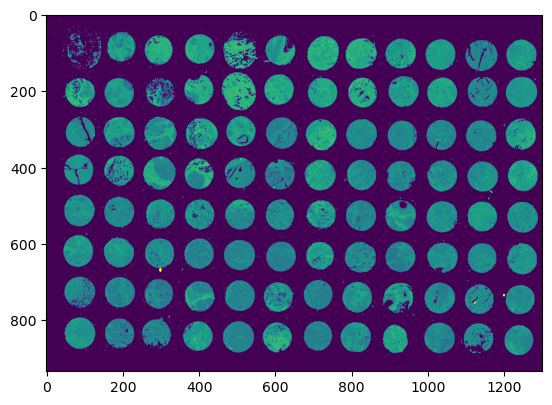

In [107]:
# display the whole image
import matplotlib.pyplot as plt

def nearest_ind(a, v):
    return np.abs(a - v).argmin()

im = data[:, :, nearest_ind(wns, 1560)]
plot = plt.imshow(im, vmin=0, vmax=1)

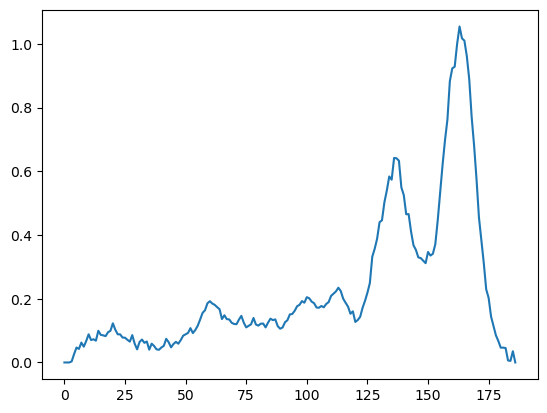

In [108]:
plt.plot(data[110, 220])

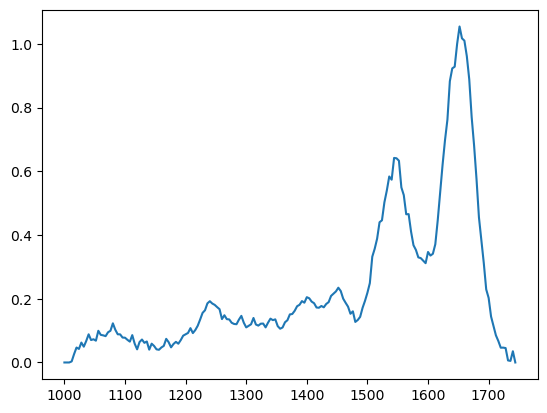

In [109]:
# a single "pixel" is a spectrum
plt.plot(wns, data[110, 220])
plt.show()

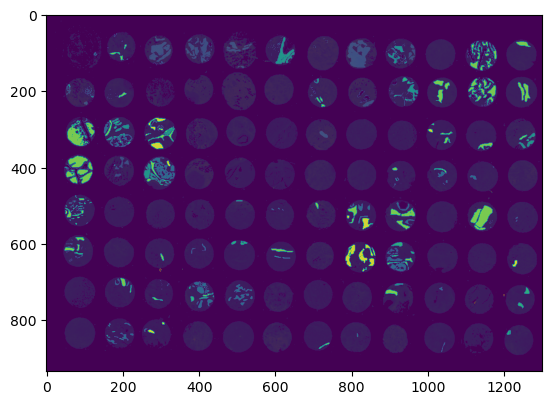

In [110]:
# the classes
plt.imshow(data[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)
plt.imshow(classes[:, :], alpha=0.8)

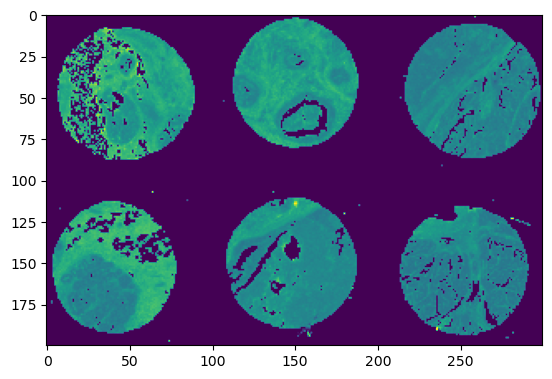

In [111]:
data_predict = data[265:465,360:660]
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

In [158]:
annotated_sel = classes != -1
X = data[annotated_sel]
y = classes[annotated_sel]

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

lr = LogisticRegression(max_iter=10000, C=0.001)
lr.fit(X, y)

LogisticRegression(C=0.001, max_iter=10000)

In [113]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

lin_pred = lr.predict_proba(lin_data_predict)
pred = lin_pred.reshape(data_predict.shape[:2] + lin_pred.shape[-1:])

with open("multilogreg.npy", "wb") as f:
    np.save(f, pred.astype(np.float32))


In [171]:
import torch.nn as nn

class SpectralMLP(nn.Module):
    def __init__(self, input_features=187, num_classes=3):
        super(SpectralMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [116]:
from torch.functional import F

class SpectralCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SpectralCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # The size here should match the output shape after convolutions
        self.fc1 = nn.Linear(64 * 43, 128)  # Correct the size based on the flattened si
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (shape becomes [batch_size, 1, num_wavelengths])
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [196]:
annotated_sel

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [205]:
np.unravel_index(annotated_indices, (rows, cols))

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [ ]:
import numpy as np

# Assume annotated_sel contains indices of selected samples
# X is the dataset containing all the samples, and annotated_sel is the selection of specific samples
X = data[annotated_sel]  # Get the features for the selected samples
annotated_indices = np.array(annotated_sel)  # Indices of annotated samples

# Get the shape of the data (for example, if data is 3D: rows, cols, channels)
rows, cols, channels = data.shape  # Shape of the original dataset

# Get the corresponding row and column positions for the selected annotated samples
row_indices, col_indices = np.unravel_index(annotated_indices, (rows, cols))

# Stack the row and column indices as position features
positions = np.vstack([row_indices, col_indices]).T


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [194]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np

annotated_sel = classes != -1
X = data[annotated_sel]  


y = classes[annotated_sel]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, stratify=y)

# Convert to tensors and move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [169]:
# Model, loss, optimizer
model = SpectralMLP(X_train.shape[1], len(np.unique(y))).to(device)
#model = SpectralCNN(X_train.shape[1], len(np.unique(y))).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Training loop with batching
epochs = 200
torch.manual_seed(42)

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU/CPU
        
        optimizer.zero_grad()

        # Forward pass
        pred_logits = model(batch_X) 

        # Compute loss
        loss = loss_fn(pred_logits, batch_y)
        loss.backward()

        # Update model weights
        optimizer.step()

        # Accumulate the loss for averaging later
        running_train_loss += loss.item()

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.inference_mode():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            val_logits = model(batch_X)
            val_loss = loss_fn(val_logits, batch_y)

            # Accumulate validation loss
            running_val_loss += val_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(val_logits, 1)
            correct_preds += (predicted == batch_y).sum().item()
            total_preds += batch_y.size(0)

    # Calculate average loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = correct_preds / total_preds

    print(f"Epoch {epoch+1}/{epochs}: Train loss={avg_train_loss:.4f}, Val loss={avg_val_loss:.4f}, Val acc={val_acc:.4f}")

Epoch 1/200: Train loss=0.4000, Val loss=0.2306, Val acc=0.9328
Epoch 2/200: Train loss=0.2405, Val loss=0.2304, Val acc=0.9055
Epoch 3/200: Train loss=0.2194, Val loss=0.2309, Val acc=0.9254
Epoch 4/200: Train loss=0.2046, Val loss=0.2151, Val acc=0.9254
Epoch 5/200: Train loss=0.1926, Val loss=0.1634, Val acc=0.9353
Epoch 6/200: Train loss=0.1795, Val loss=0.1706, Val acc=0.9428
Epoch 7/200: Train loss=0.1760, Val loss=0.1763, Val acc=0.9204
Epoch 8/200: Train loss=0.1663, Val loss=0.1797, Val acc=0.9279
Epoch 9/200: Train loss=0.1602, Val loss=0.1506, Val acc=0.9502
Epoch 10/200: Train loss=0.1542, Val loss=0.1573, Val acc=0.9453
Epoch 11/200: Train loss=0.1536, Val loss=0.1650, Val acc=0.9378
Epoch 12/200: Train loss=0.1472, Val loss=0.1592, Val acc=0.9254
Epoch 13/200: Train loss=0.1440, Val loss=0.1606, Val acc=0.9303
Epoch 14/200: Train loss=0.1431, Val loss=0.1522, Val acc=0.9428
Epoch 15/200: Train loss=0.1455, Val loss=0.1740, Val acc=0.9403
Epoch 16/200: Train loss=0.1378, V

In [152]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

tissue_mask_predict = tissue_mask[265:465,360:660]

lin_data_predict_tensor = torch.tensor(lin_data_predict, dtype=torch.float32).to(device) 

# Predict
model.eval()
with torch.inference_mode():
    pred_logits = model(lin_data_predict_tensor)
    pred_probs = torch.softmax(pred_logits, dim=1) 
    pred_labels = torch.argmax(pred_probs, dim=1)


# Reshape the predicted probabilities to match the data dimensions
pred_probs_reshaped = pred_probs.cpu().numpy().reshape(data_predict.shape[:2] + lin_pred.shape[-1:])
pred_labels_reshaped = pred_labels.cpu().numpy().reshape(data_predict.shape[:2])

background_pred = np.array([0, 1, 0, 0, 0, 0], dtype=pred_probs_reshaped.dtype)

mask_region = ~tissue_mask_predict.astype(bool)
pred_probs_reshaped[mask_region] = background_pred

# Save the probabilities
np.save("basic_prediction_probs.npy", pred_probs_reshaped.astype(np.float32))


In [ ]:
# spatial 
spatial_data = 

In [124]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

lin_pred = lr.predict_proba(lin_data_predict)
pred = lin_pred.reshape(data_predict.shape[:2] + lin_pred.shape[-1:])

with open("multilogreg.npy", "wb") as f:
    np.save(f, pred.astype(np.float32))


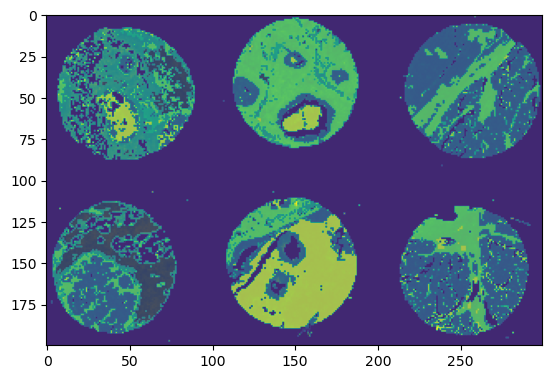

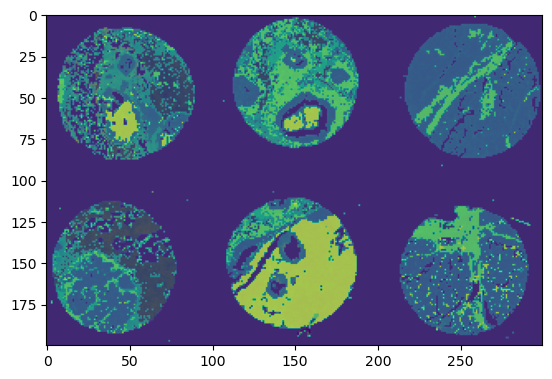

In [157]:
# Get predicted class labels
pred_labels = np.argmax(pred, axis=-1)

# Show the background reflectance map at ~1560nm
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

# Overlay predicted class labels
plt.imshow(pred_labels, alpha=0.6)
plt.show()

# Show a background image: a reflectance map at wavelength nearest to 1560
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

# Overlay the predicted labels (already reshaped)
plt.imshow(pred_labels_reshaped, alpha=0.6) 